In [1]:
%pip install -U pip
%pip install -q numpy torchcodec torchaudio ffmpeg matplotlib
%pip list |awk '/numpy|torch|ffmpeg|matplotlib/ {print $1,$2}'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ffmpeg 1.4
matplotlib 3.10.5
matplotlib-inline 0.1.7
numpy 2.2.6
torch 2.7.1
torchaudio 2.7.1
torchcodec 0.5
torchvision 0.22.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    import torchaudio as ta
    import torchaudio.transforms as T
    from torch import Tensor, arange
    from torchcodec.decoders import AudioDecoder
    from torchcodec.encoders import AudioEncoder
    import matplotlib.pyplot as plt
    import numpy as np
    from pprint import pprint
except ImportError as e:
    print(f"Import error: {e}")

In [35]:
# constants and configurations
AUDIO_FILE = "2.MP3"
TARGET_SAMPLING_RATE = 16_000
TARGET_CHANNEL_NUM = 1

In [36]:
# load audio file
audioClip = AudioDecoder(AUDIO_FILE)

# explore results
print(f"Returned Type: {type(audioClip)}. Metadata: {type(audioClip.metadata)}")

Returned Type: <class 'torchcodec.decoders._audio_decoder.AudioDecoder'>. Metadata: <class 'torchcodec._core._metadata.AudioStreamMetadata'>


In [37]:
# print loaded file metadata
pprint(audioClip.metadata)
pprint(audioClip.get_all_samples().data.shape)

AudioStreamMetadata:
  duration_seconds_from_header: 9.017125
  begin_stream_seconds_from_header: 0.0
  bit_rate: 128000.0
  codec: mp3
  stream_index: 0
  sample_rate: 44100
  num_channels: 2
  sample_format: fltp

torch.Size([2, 398592])


In [38]:
# resample audio to desired format
samples, sample_rate, sample_format = audioClip.get_all_samples().data, audioClip.metadata.sample_rate, audioClip.metadata.codec
encoder = AudioEncoder(samples, sample_rate=sample_rate)

# resample
resampledSamples: Tensor = encoder.to_tensor(format=sample_format, num_channels=TARGET_CHANNEL_NUM, sample_rate=TARGET_SAMPLING_RATE)

In [39]:
# verify resampling...
resampledClip = AudioDecoder(resampledSamples)

# view
pprint(resampledClip.metadata)
pprint(type(resampledClip))

AudioStreamMetadata:
  duration_seconds_from_header: 9.144
  begin_stream_seconds_from_header: 0.069062
  bit_rate: 24000.0
  codec: mp3
  stream_index: 0
  sample_rate: 16000
  num_channels: 1
  sample_format: fltp

<class 'torchcodec.decoders._audio_decoder.AudioDecoder'>


In [40]:
# plot functions
def waveform(clip: AudioDecoder, title: str = "Waveform Plot"):
    # sample rate & channels
    sr = clip.metadata.sample_rate
    channels = clip.metadata.num_channels

    # get samples
    samples = clip.get_all_samples().data
    nc, ns = samples.shape

    # check
    if nc != channels:
        print(f"Mismatch: reported channels in metadata: {channels} differ from Tensor shape: {samples.shape}")
    
    # plot samples
    time_scale = arange(0, ns) / sr
    values = samples[0]
    
    fig, axis = plt.subplots(nc,1)
    axis.set_xlim([0,time_scale[-1]])
    axis.plot(time_scale, values)
    axis.set_ylabel("Amplitude")
    axis.set_xlabel("Time (s)")
    axis.set_title(title)

    return (fig, axis)
    

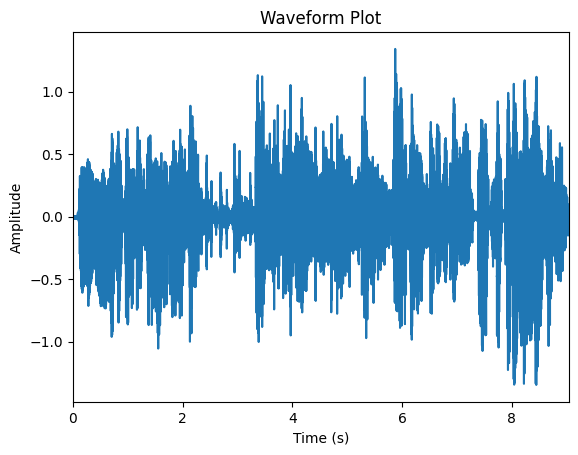

In [41]:
# plot waveform
f, a = waveform(resampledClip)

In [46]:
s = T.Spectrogram(n_fft=400)

In [47]:
d = s(resampledClip.get_all_samples().data)
print(d.shape)

torch.Size([1, 201, 724])


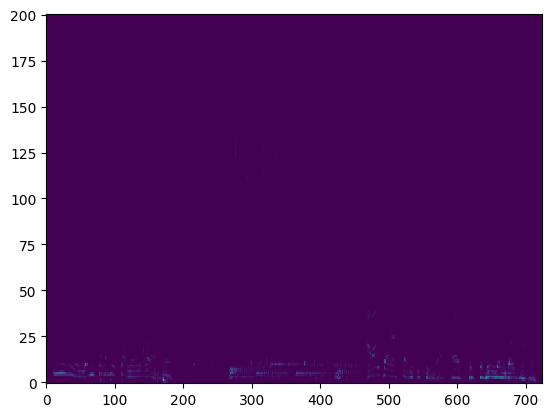

In [49]:
plt.imshow(d.squeeze(), origin="lower", aspect="auto", interpolation="nearest")